Reading Data from File...
Complete!
Filtering Signal...
Filtering done!


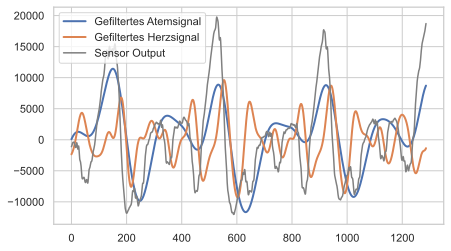

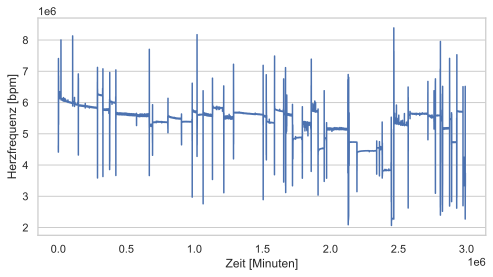

In [34]:
import SleepAnalysisDSP as sa
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = 'svg'

# read the csv file into a pandas dataframe
print("Reading Data from File...")
FILE = "Sensordata\RawData06122021.csv"
# name = "29112021_sensor_data"
data = pd.read_csv(FILE, names=["timestamp", "value"], delimiter=",")
print("Complete!")

# calculate smoothed dataset and backfill missing data from phaseshift
data["smoothed_ts"] = data["timestamp"].rolling(5, win_type="hanning").mean()
data["smoothed_v"] = data["value"].rolling(5, win_type="hanning").mean()
data["smoothed_ts"] = data["smoothed_ts"].bfill()
data["smoothed_v"] = data["smoothed_v"].bfill()
fs_sm = sa.get_sampling_freq(data["smoothed_ts"].to_numpy())

# filter (and upsample for HR) the smoothed datasets
#TODO separate the filter output and writing to dataframe. Slows down the program
print("Filtering Signal...")
l=.05
h=42
bp_filt = sa.filter_bp(l,h,data["smoothed_v"], fs_sm)
hr_filt = sa.filter_hr(data["smoothed_v"], fs_sm)
resampled_hr_filt = sa.resample(hr_filt, len(hr_filt) * 4)
rr_filt = sa.filter_rr(data["smoothed_v"], fs_sm)
print("Filtering done!")
# # write to dataframe
# data["filtered_hr"] = hr_filt
# data["filtered_rr"] = rr_filt
sns.set(rc={"figure.figsize": (7, 4)})
sns.set_style("whitegrid")

plt.plot(rr_filt[2111050:2112337], linewidth=2, label="Gefiltertes Atemsignal")
plt.plot(hr_filt[2111050:2112337], linewidth=2, label="Gefiltertes Herzsignal")
plt.plot(bp_filt[2111000:2112287], color="grey", label="Sensor Output")
plt.legend()
plt.show()
plt.plot(data["smoothed_v"])
plt.ylabel("Herzfrequenz [bpm]")
plt.xlabel("Zeit [Minuten]")
plt.grid(axis="x")
plt.tight_layout()
plt.show()

# # # write file for evaluation
# # headings = {
# #     "hr_sensor": list(map(int, heart_rates)),
# #     "rr_sensor": list(map(int, resp_rates)),
# #     "ss_sensor": list(map(int, sp_values)),
# # }
# # df = pd.DataFrame(headings)
# # print(df)
# # df.to_csv("Sensordata/clean/" + name, encoding="utf-8", index=False)

# # Create the Plot
# print("Plotting...")

# plot_dash(
#     data["smoothed_v"].to_numpy(),
#     hr_filt,
#     rr_filt,
#     heart_rates,
#     hrv,
#     resp_rates,
#     movement,
#     data["smoothed_ts"].to_numpy(),
#     hr_timecodes,
#     rr_timecodes,
#     sp_values,
#     sp_stats,
# )


Calculating Heart Rates + Heartrate Variability...


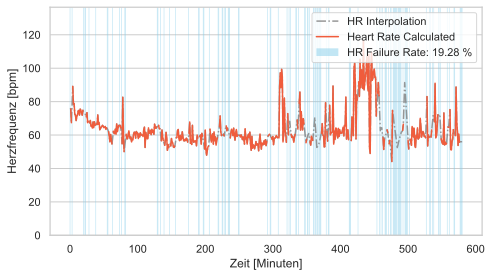

Heartrates + Heartrate Variability done!
HR Failure Rate: 19.28 %


In [35]:
# Calculate Heartrates, HRV
print("Calculating Heart Rates + Heartrate Variability...")
# ignore warnings raised by heartpy
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    heart_rates, hrv, hr_timecodes, hr_fail_rate = sa.hr_hrv(
        resampled_hr_filt, (fs_sm * 4)
    )
# remove outliers > +-5 sigma, converts to np.array
heart_rates = sa.reject_outliers(heart_rates, m=5)
# data for plot to visualize failed HR calc
hr_with_nans = np.copy(heart_rates)
hr_only_nans = np.zeros(len(heart_rates))
# interpolate to fill gaps, https://stackoverflow.com/a/6520696
nans_hr, x_hr = np.isnan(heart_rates), lambda z: z.nonzero()[0]
heart_rates[nans_hr] = np.round(
    np.interp(x_hr(nans_hr), x_hr(~nans_hr), heart_rates[~nans_hr]), 0
)
# plot all the HR calc stuff
# create array to mark the NaN values of HR-Calculation
hr_only_nans[nans_hr] = 150

plt.plot(
    heart_rates, color="grey", alpha=0.8, label="HR Interpolation", linestyle="-."
)
plt.plot(
    hr_with_nans,
    color="#F05C3C",
    alpha=1,
    linewidth=1.5,
    label="Heart Rate Calculated",
)
plt.bar(
    hr_timecodes,
    hr_only_nans,
    width=1,
    color="skyblue",
    edgecolor="none",
    alpha=0.5,
    label=f"HR Failure Rate: {hr_fail_rate * 100:.2f} %",
)
plt.ylim(top=max(heart_rates) + 20)
plt.ylabel("Herzfrequenz [bpm]")
plt.xlabel("Zeit [Minuten]")
plt.legend(loc="upper right")
plt.grid(axis="x")
plt.tight_layout()
plt.show()
# needs to be np array
hrv = np.array(hrv)
nans_hrv, x_hrv = np.isnan(hrv), lambda z: z.nonzero()[0]
hrv[nans_hrv] = np.round(
    np.interp(x_hrv(nans_hrv), x_hrv(~nans_hrv), hrv[~nans_hrv]), 0
)
print("Heartrates + Heartrate Variability done!")
print(f"HR Failure Rate: {hr_fail_rate * 100:.2f} %")

Calculating Respiratory Rates + Movement...
Respiratory Rates + Movement done!


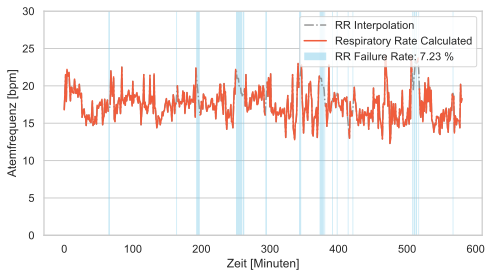

RR Failure Rate: 7.23 %


In [37]:
print("Calculating Respiratory Rates + Movement...")
resp_rates, movement, rr_timecodes, _ = sa.rr_mvt(rr_filt, fs_sm)
# remove outliers > +-5 sigma, converts to np.array
resp_rates = sa.reject_outliers(resp_rates, m=5)
# calculate new failure rate
failed = np.count_nonzero(np.isnan(resp_rates))
rr_fail_rate = failed / len(resp_rates)
# data for plot to visualize failed HR calc
rr_with_nans = np.copy(resp_rates)
rr_only_nans = np.zeros(len(resp_rates))
# interpolate to fill gaps, https://stackoverflow.com/a/6520696
nans_rr, x_rr = np.isnan(resp_rates), lambda z: z.nonzero()[0]
resp_rates[nans_rr] = np.round(
    np.interp(x_rr(nans_rr), x_rr(~nans_rr), resp_rates[~nans_rr]), 0
)
print("Respiratory Rates + Movement done!")
# create array to mark the NaN values of HR-Calculation
rr_only_nans[nans_rr] = 150

plt.plot(
    resp_rates, color="grey", alpha=0.8, label="RR Interpolation", linestyle="-."
)
plt.plot(
    rr_with_nans,
    color="#F05C3C",
    alpha=1,
    linewidth=1.5,
    label="Respiratory Rate Calculated",
)
plt.bar(
    rr_timecodes,
    rr_only_nans,
    width=1,
    color="skyblue",
    edgecolor="none",
    alpha=0.5,
    label=f"RR Failure Rate: {rr_fail_rate * 100:.2f} %",
)
plt.ylim(top=max(resp_rates) + 6)
plt.ylabel("Atemfrequenz [bpm]")
plt.xlabel("Zeit [Minuten]")
plt.legend(loc="upper right")
plt.grid(axis="x")
plt.tight_layout()
plt.show()
# needs to be np array
hrv = np.array(hrv)
nans_hrv, x_hrv = np.isnan(hrv), lambda z: z.nonzero()[0]
hrv[nans_hrv] = np.round(
    np.interp(x_hrv(nans_hrv), x_hrv(~nans_hrv), hrv[~nans_hrv]), 0
)
print(f"RR Failure Rate: {rr_fail_rate * 100:.2f} %")


In [28]:
# Determine Sleep Phases
print("Sleep Analysis...")
(
    sp_values,
    sp_stats,
    hr_avg_plot,
    rmssd_avg_plot,
    rr_avg_plot,
    mvt_avg_plot,
    hr_ref_plot,
    rmssd_ref_plot,
    rr_ref_plot,
    mvt_ref_plotv,
) = sa.sleep_phases(heart_rates, hrv, resp_rates, movement)
print("Sleep Analysis done!")
print(sp_stats)


Sleep Analysis...
Sleep Analysis done!
{'Dauer': '08:15 h', 'Tief': '02:11 h', 'Leicht': '03:37 h', 'REM': '02:13 h', 'Unterbrechungen': 1, 'Mittlere HF': '60 bpm', 'Mittlere AF': '16.6 bpm'}


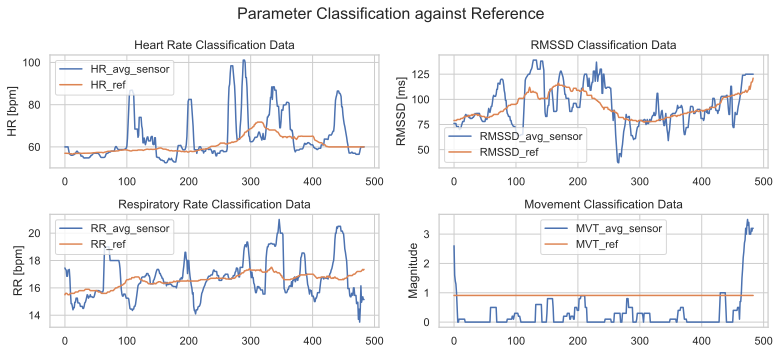

In [29]:
# plot the data of sleep phase calculation
plt.rcParams["figure.figsize"] = [11, 5]
plt.suptitle("Parameter Classification against Reference", fontsize=16)
plt.subplot(221, title="Heart Rate Classification Data", ylabel="HR [bpm]")
plt.plot(hr_avg_plot, label="HR_avg_sensor")
plt.plot(hr_ref_plot, label="HR_ref")
plt.legend()
plt.subplot(222, title="RMSSD Classification Data", ylabel="RMSSD [ms]")
plt.plot(rmssd_avg_plot, label="RMSSD_avg_sensor")
plt.plot(rmssd_ref_plot, label="RMSSD_ref")
plt.legend()
plt.subplot(223, title="Respiratory Rate Classification Data", ylabel="RR [bpm]")
plt.plot(rr_avg_plot, label="RR_avg_sensor")
plt.plot(rr_ref_plot, label="RR_ref")
plt.legend()
plt.subplot(224, title="Movement Classification Data", ylabel="Magnitude")
plt.plot(mvt_avg_plot, label="MVT_avg_sensor")
plt.plot(mvt_ref_plotv, label="MVT_ref")
plt.legend()
plt.tight_layout()
plt.show()